Dataset shape: (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month

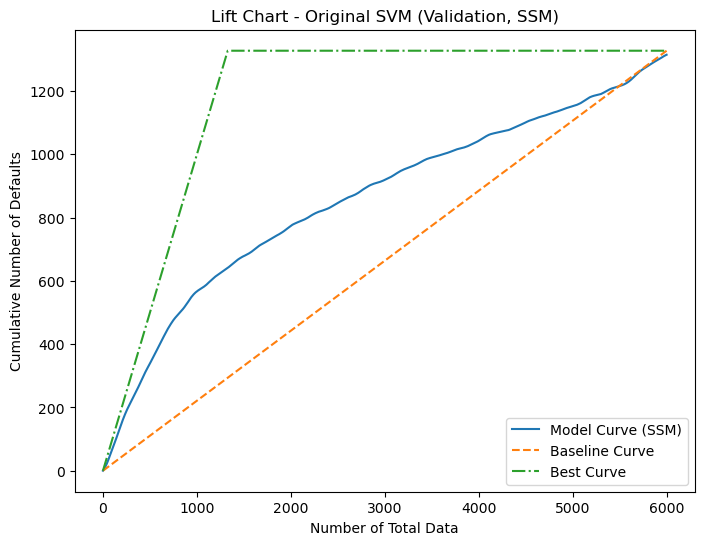

Original SVM Training Error Rate: 0.1792083333333333
Original SVM Training Area Ratio (with SSM): 0.47241527349343454

=== Enhanced SVM Implementation (Hyperparameter Tuning) ===


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Enhanced SVM - Best parameters: {'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__C': 1}
Enhanced SVM Validation Confusion Matrix:
 [[4471  202]
 [ 919  408]]

Enhanced SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.67      0.31      0.42      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.63      0.65      6000
weighted avg       0.79      0.81      0.79      6000

Enhanced SVM Validation Error Rate: 0.1868333333333333
Enhanced SVM Validation Area Ratio (with SSM): 0.37975457292892645


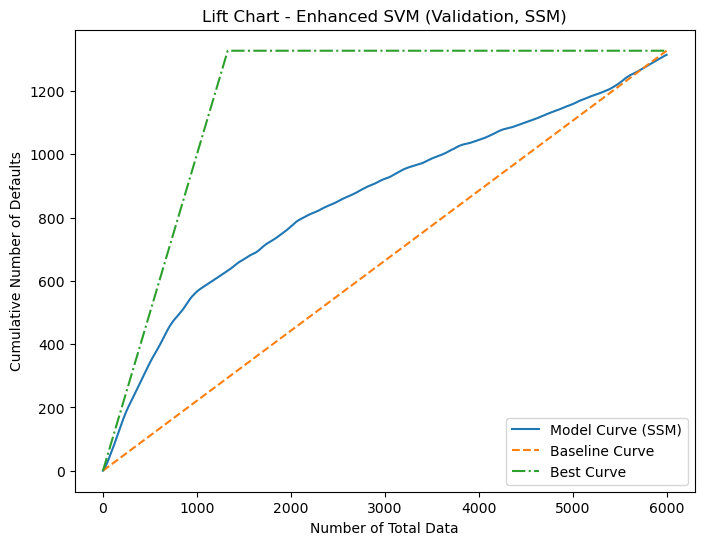

Enhanced SVM Training Error Rate: 0.17858333333333332
Enhanced SVM Training Area Ratio (with SSM): 0.4876559989703198

Comparison of Original vs. Enhanced SVM:
      Method  Error Rate (Training)  Error Rate (Validation)  Area Ratio (Training)  Area Ratio (Validation)
Original SVM               0.179208                 0.185000               0.472415                 0.378052
Enhanced SVM               0.178583                 0.186833               0.487656                 0.379755


In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# --- 1. Data Fetching and Preparation ---
# Fetch dataset (id=350) and convert to pandas DataFrame
df = pd.read_csv('default_credit_score.csv', sep=',')
print("Dataset shape:", df.shape)
print(df.head())

if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

X = df.drop("default payment next month", axis=1)
y = df["default payment next month"]

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# SSM Smoothing Function & Lift Chart Functions
# -------------------------------
def smooth_ssm(y_sorted, n=50):
    """
    Applies the Sorting Smoothing Method (SSM) using a moving average.
    """
    kernel = np.ones(2*n + 1) / (2*n + 1)
    smoothed = np.convolve(y_sorted, kernel, mode='same')
    return smoothed

def compute_area_ratio(y_true, y_score, use_ssm=True, n=50):
    """
    Computes the area ratio based on the lift chart.
    """
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices].astype(float)

    if use_ssm:
        y_smoothed = smooth_ssm(y_true_sorted, n)
    else:
        y_smoothed = y_true_sorted

    cum_defaults = np.insert(np.cumsum(y_smoothed), 0, 0)
    N = len(y_true)
    D = np.sum(y_true)
    x = np.arange(0, N + 1)
    area_model = np.trapz(cum_defaults, x)
    area_baseline = 0.5 * D * N
    area_diff = area_model - area_baseline
    best_area_diff = 0.5 * D * (N - D)
    area_ratio = area_diff / best_area_diff if best_area_diff != 0 else None
    return area_ratio, x, cum_defaults, D

def plot_lift_chart(x, cum_defaults, D, N, title):
    """
    Plots the lift chart showing the model curve (smoothed), baseline, and best curve.
    """
    baseline = (D / N) * x
    best_curve = np.minimum(x, D)
    plt.figure(figsize=(8, 6))
    plt.plot(x, cum_defaults, label='Model Curve (SSM)')
    plt.plot(x, baseline, label='Baseline Curve', linestyle='--')
    plt.plot(x, best_curve, label='Best Curve', linestyle='-.')
    plt.xlabel("Number of Total Data")
    plt.ylabel("Cumulative Number of Defaults")
    plt.title(title)
    plt.legend()
    plt.show()

# ===============================
# ORIGINAL SVM IMPLEMENTATION
# ===============================
print("\n=== Original SVM Implementation ===")
# Build the SVM pipeline (using fixed parameters)
original_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(probability=True, C=1.0, gamma='scale', random_state=42))
])
original_pipeline.fit(X_train, y_train)

# Predictions and basic evaluation (Validation)
orig_y_pred = original_pipeline.predict(X_test)
orig_y_prob = original_pipeline.predict_proba(X_test)[:, 1]

orig_cm = confusion_matrix(y_test, orig_y_pred)
orig_report = classification_report(y_test, orig_y_pred)
orig_accuracy = accuracy_score(y_test, orig_y_pred)
orig_error_rate = 1 - orig_accuracy
orig_area_ratio_val, x_val, cum_defaults_val, D_val = compute_area_ratio(y_test, orig_y_prob, use_ssm=True, n=50)

print("Original SVM Validation Confusion Matrix:\n", orig_cm)
print("\nOriginal SVM Validation Classification Report:\n", orig_report)
print("Original SVM Validation Error Rate:", orig_error_rate)
print("Original SVM Validation Area Ratio (with SSM):", orig_area_ratio_val)

plot_lift_chart(x_val, cum_defaults_val, D_val, len(y_test), "Lift Chart - Original SVM (Validation, SSM)")

# Training evaluation for original SVM
orig_y_train_pred = original_pipeline.predict(X_train)
orig_y_train_prob = original_pipeline.predict_proba(X_train)[:, 1]
orig_train_accuracy = accuracy_score(y_train, orig_y_train_pred)
orig_train_error_rate = 1 - orig_train_accuracy
orig_area_ratio_train, x_train, cum_defaults_train, D_train = compute_area_ratio(y_train, orig_y_train_prob, use_ssm=True, n=50)

print("Original SVM Training Error Rate:", orig_train_error_rate)
print("Original SVM Training Area Ratio (with SSM):", orig_area_ratio_train)

# ===============================
# ENHANCED SVM IMPLEMENTATION (with Hyperparameter Tuning)
# ===============================
print("\n=== Enhanced SVM Implementation (Hyperparameter Tuning) ===")
# Use the same pipeline structure
enhanced_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# Define a smaller parameter grid for faster search
param_distributions = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.001, 0.01],
    'svm__kernel': ['rbf']
}

# Use RandomizedSearchCV with 2-fold cross-validation
random_search = RandomizedSearchCV(
    enhanced_pipeline,
    param_distributions,
    scoring='precision',
    cv=2,
    n_jobs=-1,
    n_iter=5,
    random_state=42
)
random_search.fit(X_train, y_train)
print("Enhanced SVM - Best parameters:", random_search.best_params_)

# Use the best estimator from hyperparameter tuning
enhanced_svm = random_search.best_estimator_

# Predictions and basic evaluation (Validation) for enhanced SVM
enh_y_pred = enhanced_svm.predict(X_test)
enh_y_prob = enhanced_svm.predict_proba(X_test)[:, 1]

enh_cm = confusion_matrix(y_test, enh_y_pred)
enh_report = classification_report(y_test, enh_y_pred)
enh_accuracy = accuracy_score(y_test, enh_y_pred)
enh_error_rate = 1 - enh_accuracy
enh_area_ratio_val, x_val_enh, cum_defaults_val_enh, D_val_enh = compute_area_ratio(y_test, enh_y_prob, use_ssm=True, n=50)

print("Enhanced SVM Validation Confusion Matrix:\n", enh_cm)
print("\nEnhanced SVM Validation Classification Report:\n", enh_report)
print("Enhanced SVM Validation Error Rate:", enh_error_rate)
print("Enhanced SVM Validation Area Ratio (with SSM):", enh_area_ratio_val)

plot_lift_chart(x_val_enh, cum_defaults_val_enh, D_val_enh, len(y_test), "Lift Chart - Enhanced SVM (Validation, SSM)")

# Training evaluation for enhanced SVM
enh_y_train_pred = enhanced_svm.predict(X_train)
enh_y_train_prob = enhanced_svm.predict_proba(X_train)[:, 1]
enh_train_accuracy = accuracy_score(y_train, enh_y_train_pred)
enh_train_error_rate = 1 - enh_train_accuracy
enh_area_ratio_train, x_train_enh, cum_defaults_train_enh, D_train_enh = compute_area_ratio(y_train, enh_y_train_prob, use_ssm=True, n=50)

print("Enhanced SVM Training Error Rate:", enh_train_error_rate)
print("Enhanced SVM Training Area Ratio (with SSM):", enh_area_ratio_train)

# ===============================
# Comparison Table: Original vs. Enhanced SVM
# ===============================
results = {
    'Method': ['Original SVM', 'Enhanced SVM'],
    'Error Rate (Training)': [orig_train_error_rate, enh_train_error_rate],
    'Error Rate (Validation)': [orig_error_rate, enh_error_rate],
    'Area Ratio (Training)': [orig_area_ratio_train, enh_area_ratio_train],
    'Area Ratio (Validation)': [orig_area_ratio_val, enh_area_ratio_val]
}
results_df = pd.DataFrame(results)
print("\nComparison of Original vs. Enhanced SVM:")
print(results_df.to_string(index=False))


# Model Comparison Conclusions

This document summarizes and compares the performance of different classification modules applied on the dataset (id=350). The models compared are:

- **SVM Modules:**
  - Original SVM Implementation
  - Enhanced SVM Implementation

- **Classification Trees Module**

---

## SVM Modules Performance

### Original SVM Implementation
- **Validation Error Rate:** 18.50%
- **Validation Area Ratio (with SSM):** 0.3783
- **Training Error Rate:** 17.92%
- **Training Area Ratio (with SSM):** 0.4738

### Enhanced SVM Implementation (Hyperparameter Tuning)
- **Best Parameters Found:** `{'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__C': 1}`
- **Validation Error Rate:** 18.68%
- **Validation Area Ratio (with SSM):** 0.3793
- **Training Error Rate:** 17.86%
- **Training Area Ratio (with SSM):** 0.4872

---

## Classification Trees Module Performance

- **Validation Error Rate:** 18.15%
- **Validation Area Ratio (with SSM):** 0.4525
- **Training Error Rate:** 17.71%
- **Training Area Ratio (with SSM):** 0.4916

---

## Overall Conclusions

- **SVM Comparison:**  
  Both the original and enhanced SVM implementations perform very similarly. The enhanced SVM—tuned on the full training set—shows only marginal differences in error rate and area ratio. This indicates that the default parameters for the SVM are already well-suited for this dataset.

- **Classification Trees vs. SVM:**  
  The classification trees module exhibits a slightly lower validation error rate and a notably higher validation area ratio compared to both SVM models. This suggests that the classification trees module may be more effective at capturing the underlying patterns in the data, especially when lift performance is a key consideration.

- **Recommendation:**  
  For this dataset, the classification trees module is preferred if the primary goal is to maximize lift performance. While the SVM models perform comparably, further investigation into alternative SVM parameter ranges or additional tuning strategies may be required to achieve significant improvements over the current configuration.


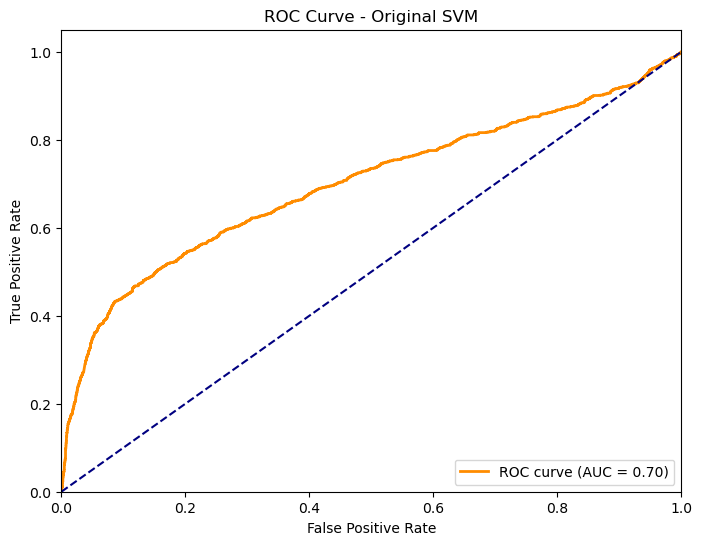

AUC Score: 0.6982


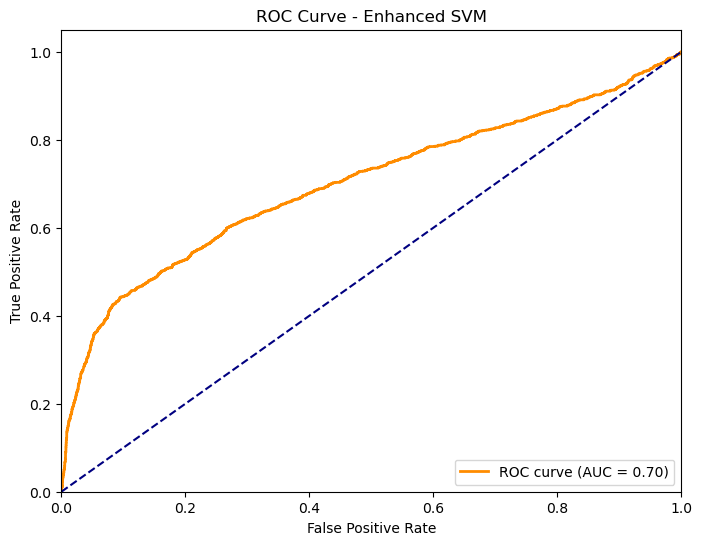

AUC Score: 0.6994


In [2]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_test, y_prob, title="ROC Curve"):
    """
    Plots the ROC curve and calculates AUC.
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # 대각선 기준선
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    print(f"AUC Score: {roc_auc:.4f}")

# 기존 SVM 모델의 ROC-AUC
plot_roc_auc(y_test, orig_y_prob, title="ROC Curve - Original SVM")

# 튜닝된 SVM 모델의 ROC-AUC
plot_roc_auc(y_test, enh_y_prob, title="ROC Curve - Enhanced SVM")